<h1>MatLab_Apply_Geo_SaveAs_vtk</h1>
<p>by Farnyuh Menq</p>
<p>NHERI@UTexas site Manager</p>
<p>2017/10/25</p>
<p>This notebook open a MatLab data file, apply geophone calibrtion factor and save data in vtk file to be ploted in Paraview.</p>

In [1]:
# import all the libraries needed
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import math
import os 

<h1>Step 1: Read channel map and calibration factors from an csv file. </h1>

In [5]:
#folder = r'C:\Users\fymenq.CAEE-MENQNHERI2\Desktop\201710_Sinkhole'
#folder = folder + '\\'
filename =  'Sinkhole_cal_ChMap.csv'
# Read csv file 
Cal_Fac = np.genfromtxt(folder + filename, delimiter=',', skip_header=1)
print (Cal_Fac)

[[   1.          225.            0.            0.           12.            1.
            nan    4.80631984    2.05568905    0.67638437    1.            1.        ]
 [   2.          235.            0.            0.           11.            1.
            nan    4.80631984    2.05568905    0.67638437    1.            1.        ]
 [   3.          245.            0.            0.           10.            1.
            nan    4.80631984    2.05568905    0.67638437    1.            1.        ]
 [   4.          255.            0.            0.            9.            1.
            nan    4.80631984    2.05568905    0.67638437    1.            1.        ]
 [   5.          265.            0.            0.            8.            1.
            nan    4.80631984    2.05568905    0.67638437    1.            1.        ]
 [   6.          275.            0.            0.            7.            1.
            nan    4.80631984    2.05568905    0.67638437    1.            1.        ]
 [   7.   

<h1>Step 2: Open the MatLab data file</h1>

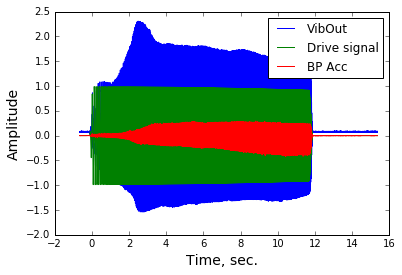

In [70]:
folder = r'C:\Users\fymenq.CAEE-MENQNHERI2\Desktop\201710_Sinkhole\20171024\20171024 Sinkhole test.syn\MATLAB'
folder = folder + '\\'

MatLab_filename =  'DPsv00040.mat' # Shaker location Q-230
# Read MatLab file using the sio library
my_data = sio.loadmat(folder + MatLab_filename)
plt.plot (my_data['X50'][:,0], my_data['X50'][:,1],
         my_data['X49'][:,0], my_data['X49'][:,1],
         my_data['X51'][:,0], my_data['X51'][:,1])
# Create xlabel
plt.xlabel('Time, sec.', fontsize=14);
# Create ylabel
plt.ylabel('Amplitude', fontsize=14);
# set limits
#plt.ylim(0.0001, 1)
#plt.xlim(-0.015, 0.02)
plt.legend(['VibOut',
            'Drive signal', 
            'BP Acc'], loc=1)
plt.show()
#print (len(my_data['X50'][:,0]))

<h1>Step 3: read Sinkhole array Model data.</h1>

In [71]:
filename = "UOF_Header.vtk"
f= open(filename,'r')
model_data = f.read()
f.close()
#print (model_data)

<h1>Step 4: Define geophone calibration function.</h1>

In [72]:
def Apply_Geophone_Cal (dt, y, fn, G, D):
    '''
    Modified from Apply_Geophone_Cal.m MatLab Function
    # function [y1] = Apply_Geophone_Cal (dt, y, fn, G, D)
    # Apply geophone calibration spectrum on a time record 
    # By Farn-Yuh Menq and Clark R Wilson at NEES@UTexas 2012/2/14
    #
    # dt is delta time between data point 
    # y is the original time record
    # fn is the natural frequency of the geophone
    # G is the calibration factor (V/in.
    # D is damping ratio (not in #)
    # y1 is the time record with the applied calibration factors (including
    # amplitide and phase)
    #
    # This function transfer input time record (y) in to freq domain (Y), multiply
    # Y with the geophone calibration cruve (geo), and transfer it back to time
    # domain as y1.
    '''

    fs = 1.0/dt                    # Sampling frequency
    N = len(y)               # Length of signal

    # FFT
    Y = (np.fft.fft(y))*2.0/N
    # frequency array
    #f = [0:1/dt/N:1/2/dt]
    f = np.linspace (0, fs/2, N/2+1)

    # Generate a Geophone response (calibration) curve
    geo_amp = np.zeros(N)  # geophone calibration curve amplitude
    geo_phs = np.zeros(N)  # geophone calibration curve phase
    geo = np.zeros((N), np.complex64)      # geophone calibration curve complex number
    Y_cal = np.zeros((N), np.complex64)      # applied FFT(y) / geo
    geo_amp= G * f**2/((fn**2-f**2)**2+(2*D*fn*f)**2)**0.5
    
    for j in range (0, int(N/2+1)):
        #geo_amp[j]= G * f[j]**2/((fn**2-f[j]**2)**2+(2*D*fn*f[j])**2)**0.5
        if (fn**2-f[j]**2) == 0:
            geo_phs[j]= -np.pi/2.0
        else:
            geo_phs[j]= -math.atan(2*D*fn*f[j]/(fn**2-f[j]**2))
        if geo_phs[j] > 0:
            geo_phs[j] = geo_phs[j] - np.pi
        geo[j] = geo_amp[j] * np.cos(geo_phs[j]) + geo_amp[j] * np.sin(geo_phs[j])*1j
        if j > 0: 
           geo[-j]= np.conj(geo[j])
        # Devide FFT Original signal with calibration factor - Transfer function
        if geo[j] != 0:
            Y_cal[j] = Y[j]/geo[j]
            Y_cal[-j] = Y[-j]/geo[-j]
        else:
            Y_cal[j] = 0.0
            Y_cal[-j] = 0.0

   
    # set 0 to first n_0 data points - geophones do not work well at low
    # frequency range
    n_0 = int(fn*0.1*fs)
    if n_0 ==0: n_0= 3
    if n_0 > 10: n_0 = 10
    for j in range (-n_0, n_0+1):
        Y_cal[j] = 0
    Y_cal[int(N/2)] = 0  # Set the value at the Nyquist frequency to 0 to ensure
    #no imagary part. 

    # Inverse FFT
    Y_cal = Y_cal * N/2.0
    y1=np.fft.ifft(Y_cal)
    if y1.imag.max() < 1e-10:
        y1 = y1.real
    return y1


<h1>Step 5: Apply Geophone calibration factor to each time record.</h1>

In [73]:
conv_data = np.zeros((48, len(my_data['X1'][:,0])))
Ch_name = ['X1', 'X2','X3', 'X4','X5', 'X6','X7', 'X8','X9', 'X10',
           'X11', 'X12','X13', 'X14','X15', 'X16','X17', 'X18','X19', 'X20',
           'X21', 'X22','X23', 'X24','X25', 'X26','X27', 'X28','X29', 'X30',
           'X31', 'X32','X33', 'X34','X35', 'X36','X37', 'X38','X39', 'X40',
           'X41', 'X42','X43', 'X44','X45', 'X46','X47', 'X48',]
samping_rate = (my_data['X1'][-1,0] - my_data['X1'][0,0])/(len(my_data['X1'][:,0])-1)
for i in range(48):
    # update calibration factor to account the gain setting of the DAS
    # G * DAS gain
    Cal_Fac_G = Cal_Fac[i, 8] * Cal_Fac[i, 11]
    # apply geophone calibration and put the result in conv_data
    # note conv_data is in sequency of sensor location, my_data is in sequency of channels
    
    conv_data[i, :] = Apply_Geophone_Cal(samping_rate,
            my_data[Ch_name[int(Cal_Fac[i, 4]-1)]][:,1]  * Cal_Fac[i, 10], # Cal_Fac[i, 10] is the polirity use "-1" for reverse
            fn = Cal_Fac[i, 7], G = Cal_Fac_G, D = Cal_Fac[i, 9])
    

0.0001220703125


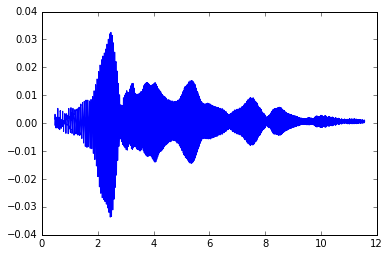

In [75]:
plt.plot (my_data['X1'][9000:100000,0], my_data['X1'][9000:100000,1])
print (samping_rate)

In [91]:
print(my_data['X1'][102000,0])
print (1/samping_rate/10/15)

11.8111572266
54.6133333333


<h1>Step 6: Save vtk file.</h1>

In [89]:
# define the step number that will be use to for video
# Fro all data in the file use: range(0,my_data[0].stats.npts)
stepnumber = range(9000, 100000, 10) # every 10 points
# set folder and file name for the output vtk file

# creat a folder to save all the vtk files
out_folder = MatLab_filename.replace('.mat', '')
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
folder = os.getcwd() +'\\' + out_folder + '\\'

for i in stepnumber:
    print (i)
    _a = str(i)
    _n_zero = 4- len(_a)
    for i in range (_n_zero):
        _a = '0' + _a
    filename = 'file' + _a +'.vtk'
    # write Levee Model data
    f= open(folder + filename,'w')
    f.write(model_data)
    # write time data of "stepnumber" to the output vtk file
    for j in range(48):
        f.write(str(conv_data[j, i])+ ' \n')
    f.close()
    


9000
9010
9020
9030
9040
9050
9060
9070
9080
9090
9100
9110
9120
9130
9140
9150
9160
9170
9180
9190
9200
9210
9220
9230
9240
9250
9260
9270
9280
9290
9300
9310
9320
9330
9340
9350
9360
9370
9380
9390
9400
9410
9420
9430
9440
9450
9460
9470
9480
9490
9500
9510
9520
9530
9540
9550
9560
9570
9580
9590
9600
9610
9620
9630
9640
9650
9660
9670
9680
9690
9700
9710
9720
9730
9740
9750
9760
9770
9780
9790
9800
9810
9820
9830
9840
9850
9860
9870
9880
9890
9900
9910
9920
9930
9940
9950
9960
9970
9980
9990
10000
10010
10020
10030
10040
10050
10060
10070
10080
10090
10100
10110
10120
10130
10140
10150
10160
10170
10180
10190
10200
10210
10220
10230
10240
10250
10260
10270
10280
10290
10300
10310
10320
10330
10340
10350
10360
10370
10380
10390
10400
10410
10420
10430
10440
10450
10460
10470
10480
10490
10500
10510
10520
10530
10540
10550
10560
10570
10580
10590
10600
10610
10620
10630
10640
10650
10660
10670
10680
10690
10700
10710
10720
10730
10740
10750
10760
10770
10780
10790
10800
10810
10820
10

23220
23230
23240
23250
23260
23270
23280
23290
23300
23310
23320
23330
23340
23350
23360
23370
23380
23390
23400
23410
23420
23430
23440
23450
23460
23470
23480
23490
23500
23510
23520
23530
23540
23550
23560
23570
23580
23590
23600
23610
23620
23630
23640
23650
23660
23670
23680
23690
23700
23710
23720
23730
23740
23750
23760
23770
23780
23790
23800
23810
23820
23830
23840
23850
23860
23870
23880
23890
23900
23910
23920
23930
23940
23950
23960
23970
23980
23990
24000
24010
24020
24030
24040
24050
24060
24070
24080
24090
24100
24110
24120
24130
24140
24150
24160
24170
24180
24190
24200
24210
24220
24230
24240
24250
24260
24270
24280
24290
24300
24310
24320
24330
24340
24350
24360
24370
24380
24390
24400
24410
24420
24430
24440
24450
24460
24470
24480
24490
24500
24510
24520
24530
24540
24550
24560
24570
24580
24590
24600
24610
24620
24630
24640
24650
24660
24670
24680
24690
24700
24710
24720
24730
24740
24750
24760
24770
24780
24790
24800
24810
24820
24830
24840
24850
24860
24870
2488

37180
37190
37200
37210
37220
37230
37240
37250
37260
37270
37280
37290
37300
37310
37320
37330
37340
37350
37360
37370
37380
37390
37400
37410
37420
37430
37440
37450
37460
37470
37480
37490
37500
37510
37520
37530
37540
37550
37560
37570
37580
37590
37600
37610
37620
37630
37640
37650
37660
37670
37680
37690
37700
37710
37720
37730
37740
37750
37760
37770
37780
37790
37800
37810
37820
37830
37840
37850
37860
37870
37880
37890
37900
37910
37920
37930
37940
37950
37960
37970
37980
37990
38000
38010
38020
38030
38040
38050
38060
38070
38080
38090
38100
38110
38120
38130
38140
38150
38160
38170
38180
38190
38200
38210
38220
38230
38240
38250
38260
38270
38280
38290
38300
38310
38320
38330
38340
38350
38360
38370
38380
38390
38400
38410
38420
38430
38440
38450
38460
38470
38480
38490
38500
38510
38520
38530
38540
38550
38560
38570
38580
38590
38600
38610
38620
38630
38640
38650
38660
38670
38680
38690
38700
38710
38720
38730
38740
38750
38760
38770
38780
38790
38800
38810
38820
38830
3884

50880
50890
50900
50910
50920
50930
50940
50950
50960
50970
50980
50990
51000
51010
51020
51030
51040
51050
51060
51070
51080
51090
51100
51110
51120
51130
51140
51150
51160
51170
51180
51190
51200
51210
51220
51230
51240
51250
51260
51270
51280
51290
51300
51310
51320
51330
51340
51350
51360
51370
51380
51390
51400
51410
51420
51430
51440
51450
51460
51470
51480
51490
51500
51510
51520
51530
51540
51550
51560
51570
51580
51590
51600
51610
51620
51630
51640
51650
51660
51670
51680
51690
51700
51710
51720
51730
51740
51750
51760
51770
51780
51790
51800
51810
51820
51830
51840
51850
51860
51870
51880
51890
51900
51910
51920
51930
51940
51950
51960
51970
51980
51990
52000
52010
52020
52030
52040
52050
52060
52070
52080
52090
52100
52110
52120
52130
52140
52150
52160
52170
52180
52190
52200
52210
52220
52230
52240
52250
52260
52270
52280
52290
52300
52310
52320
52330
52340
52350
52360
52370
52380
52390
52400
52410
52420
52430
52440
52450
52460
52470
52480
52490
52500
52510
52520
52530
5254

64780
64790
64800
64810
64820
64830
64840
64850
64860
64870
64880
64890
64900
64910
64920
64930
64940
64950
64960
64970
64980
64990
65000
65010
65020
65030
65040
65050
65060
65070
65080
65090
65100
65110
65120
65130
65140
65150
65160
65170
65180
65190
65200
65210
65220
65230
65240
65250
65260
65270
65280
65290
65300
65310
65320
65330
65340
65350
65360
65370
65380
65390
65400
65410
65420
65430
65440
65450
65460
65470
65480
65490
65500
65510
65520
65530
65540
65550
65560
65570
65580
65590
65600
65610
65620
65630
65640
65650
65660
65670
65680
65690
65700
65710
65720
65730
65740
65750
65760
65770
65780
65790
65800
65810
65820
65830
65840
65850
65860
65870
65880
65890
65900
65910
65920
65930
65940
65950
65960
65970
65980
65990
66000
66010
66020
66030
66040
66050
66060
66070
66080
66090
66100
66110
66120
66130
66140
66150
66160
66170
66180
66190
66200
66210
66220
66230
66240
66250
66260
66270
66280
66290
66300
66310
66320
66330
66340
66350
66360
66370
66380
66390
66400
66410
66420
66430
6644

78670
78680
78690
78700
78710
78720
78730
78740
78750
78760
78770
78780
78790
78800
78810
78820
78830
78840
78850
78860
78870
78880
78890
78900
78910
78920
78930
78940
78950
78960
78970
78980
78990
79000
79010
79020
79030
79040
79050
79060
79070
79080
79090
79100
79110
79120
79130
79140
79150
79160
79170
79180
79190
79200
79210
79220
79230
79240
79250
79260
79270
79280
79290
79300
79310
79320
79330
79340
79350
79360
79370
79380
79390
79400
79410
79420
79430
79440
79450
79460
79470
79480
79490
79500
79510
79520
79530
79540
79550
79560
79570
79580
79590
79600
79610
79620
79630
79640
79650
79660
79670
79680
79690
79700
79710
79720
79730
79740
79750
79760
79770
79780
79790
79800
79810
79820
79830
79840
79850
79860
79870
79880
79890
79900
79910
79920
79930
79940
79950
79960
79970
79980
79990
80000
80010
80020
80030
80040
80050
80060
80070
80080
80090
80100
80110
80120
80130
80140
80150
80160
80170
80180
80190
80200
80210
80220
80230
80240
80250
80260
80270
80280
80290
80300
80310
80320
8033

92410
92420
92430
92440
92450
92460
92470
92480
92490
92500
92510
92520
92530
92540
92550
92560
92570
92580
92590
92600
92610
92620
92630
92640
92650
92660
92670
92680
92690
92700
92710
92720
92730
92740
92750
92760
92770
92780
92790
92800
92810
92820
92830
92840
92850
92860
92870
92880
92890
92900
92910
92920
92930
92940
92950
92960
92970
92980
92990
93000
93010
93020
93030
93040
93050
93060
93070
93080
93090
93100
93110
93120
93130
93140
93150
93160
93170
93180
93190
93200
93210
93220
93230
93240
93250
93260
93270
93280
93290
93300
93310
93320
93330
93340
93350
93360
93370
93380
93390
93400
93410
93420
93430
93440
93450
93460
93470
93480
93490
93500
93510
93520
93530
93540
93550
93560
93570
93580
93590
93600
93610
93620
93630
93640
93650
93660
93670
93680
93690
93700
93710
93720
93730
93740
93750
93760
93770
93780
93790
93800
93810
93820
93830
93840
93850
93860
93870
93880
93890
93900
93910
93920
93930
93940
93950
93960
93970
93980
93990
94000
94010
94020
94030
94040
94050
94060
9407